# Bayesian Optimization

The content of this notebook is adapted from [A Tutorial on Bayesian Optimization of Expensive Cost Functions](https://arxiv.org/pdf/1012.2599.pdf) by E. Brochu, V.M. Cora, and N. de Freitas and from this [blog post](http://krasserm.github.io/2018/03/21/bayesian-optimization/) by [Martin Krasser](http://krasserm.github.io/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
import bayesian_optimization_util as bou

%config InlineBackend.figure_format = 'retina'
#from importlib import reload
#reload(bou)

# Global Optimization

Given a nonlinear function $f(\mathbf{x})$, the goal of [global optimization](https://en.wikipedia.org/wiki/Global_optimization#:~:targetText=Global%20optimization%20is%20a%20branch,functions%20on%20a%20given%20set.) is to find the value of $\mathbf{x}$ within some bounded region of interest $\mathcal{A}$ where for which the function achieves its maximum value 

$$ \max_{\mathbf{x}\in\mathcal{A}\subset  \mathbb{R}^d} f(\mathbf{x}) $$

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is a sequential design strategy for the global optimization of "black-box" functions that are expensive to evaluate. By "black-box", we mean that the objective function is known to us only though noisy function evaluations, $y_{1:t} = \{y_1,\dots y_{t}\}$ where $y_i= f(\mathbf{x}_i)+\varepsilon_i$. Treating these function evaluations as data $\mathcal{D}_{1:t} = \{\mathbf{x}_{1:t}, y_{1:t}\}$, we construct a posterior distribution for the objective function $p(f\mid\mathcal{D}_{1:t})$, which guides the selection of the next sampling point $\mathbf{x}_{t+1}$.  Here, we use a *Gaussian process* to describe the distributions over functions.

## Algorithm

The Bayesian optimization procedure is as follows. For $t=1,2,\dots$ repeat:

- Obtain a noisy sample $y_t= f(\mathbf{x}_t)+\varepsilon_t$ from the objective function $f$.
- Find the next sampling point $\mathbf{x}_{t+1}$ by optimizing the *acquisition function* over the Gaussian process: $\mathbf{x}_{t+1}=\mathrm{argmax}_{\mathbf{x}}u(\mathbf{x}\mid \mathcal{D}_{1:t})$
- Add the sample to previous samples $\mathcal{D}_{1:t+1}=\{\mathcal{D}_{1:t},(\mathbf{x}_{t+1},y_{t+1})\}$ and update the Gaussian process.

The acquisition function is chosen to balance the competing requiremements of *exploration* (favoring points where the objective function is very uncertain) and *exploitation* (favoring points where the objective function is expected to be high). Ideally, the aquisition function aims to identify the global maximum (to within some specified precision) using the fewest number of function evaluations. 

## Gaussian process

We model our noisy evaluations of the objective function as 

$$y = f(\mathbf{x}) + \varepsilon$$

where $\varepsilon\sim\mathcal{N}(0,\sigma_n^2)$ is Gaussian noise of magnitude $\sigma_n$.  The objective function is approximated as a gaussian process

$$ f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) $$

with mean function $m(\mathbf{x})$ and covariance function (kernel) $k(\mathbf{x},\mathbf{x}')$.  For convenience, we assume here that the prior mean is the zero function, $m(\mathbf{x}) = 0$; note that the mean of the posterior process is not confined to be zero (see [RW2006](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) section 2.7).

Given a set of previous function evaluations $\mathcal{D}_{1:t} = \{\mathbf{x}_{1:t}, \mathbf{y}_{1:t}\}$, we use Gaussian process regression to obtain the predictive distribution for next function evaluation at $\mathbf{x}_{t+1}$ denoted $y_{t+1}$.  The joint distribution is 

$$ \begin{bmatrix} \mathbf{y}_{1:t} \\ y_{t+1} \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} + \sigma_n^2\mathbf{I}  & \mathbf{k} \\  \mathbf{k}^{T} & k(\mathbf{x}_{t+1},\mathbf{x}_{t+1}) \end{bmatrix} \right) $$

where 

$$ \mathbf{K} = \begin{bmatrix} k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1,\mathbf{x}_t)
\\  \vdots & \ddots & \vdots
\\  k(\mathbf{x}_t,\mathbf{x}_1) & \dots & k(\mathbf{x}_{t},\mathbf{x}_{t})\end{bmatrix} \quad \text{and} \quad \mathbf{k} = \begin{bmatrix} k(\mathbf{x}_{t+1},\mathbf{x}_1) &\dots & k(\mathbf{x}_{t+1},\mathbf{x}_{t})\end{bmatrix}$$

The corresponding conditional distribution that predicts the outcome of the next function evaluation is 

$$ f_{t+1} \mid \mathcal{D}_{1:t}, \mathbf{x}_{t+1} \sim \mathcal{N}\left( \mu_t(\mathbf{x}_{t+1}), \sigma_t^2(\mathbf{x}_{t+1})\right) $$

$$ y_{t+1} \mid \mathcal{D}_{1:t}, \mathbf{x}_{t+1} \sim \mathcal{N}\left( \mu_t(\mathbf{x}_{t+1}), \sigma_t^2(\mathbf{x}_{t+1})+\sigma_n^2\right) $$

where the mean and covariance are 

$$ \mu_t(\mathbf{x}_{t+1})= \mathbf{k}^{T}[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1} \mathbf{y}_{1:t} $$

$$ \sigma_t^2(\mathbf{x}_{t+1}) = k(\mathbf{x}_{t+1},\mathbf{x}_{t+1}) − \mathbf{k}^T[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1} \mathbf{k}$$

This result is identical to that presented in the previous lecture on Gaussian processes; however, the notation is slightly different.

## Expected improvement

We will focus on a particular acquisition function call *expected improvement* $\mathrm{EI}(\mathbf{x})$.  The improvement function is defined as 

$$ \mathrm{I}(\mathbf{x}) = \max \{0, f_{t+1}(\mathbf{x}) - \mu_t^+ \} $$

where $\mu_t^+ = \mathrm{argmax}_{\mathbf{x}_i\in \mathbf{x}_{1:t}} \mu_t(\mathbf{x}_i) $. That is, $\mathrm{I}(\mathbf{x})$ is positive when the predicted function evaluation is higher than the best value known thus far; otherwise, $I(x)$ is set to zero. The new query point is found by maximizing the expected improvement:

$$ \mathbf{x}_{t+1} = \mathrm{argmax}_{\mathbf{x}}  \mathbb{E}(\mathrm{I}(\mathbf{x}) )$$

The probability density function for improvement $\mathrm{I}$ at some $\mathbf{x}$ is given by 

$$ p(\mathrm{I}\mid \mu_t, \sigma^2_t, \mu_t^+) = \int p(\mathrm{I}\mid f_{t+1},\mu_t^+) p(f_{t+1}\mid\mu_t, \sigma^2_t) df_{t+1}$$

$$ p(\mathrm{I}\mid \mu_t, \sigma^2_t, \mu_t^+) = \int \delta(\mathrm{I} - \max \{0, f_{t+1}- \mu_t^+ \}) p(f_{t+1}\mid\mu_t, \sigma^2_t) df_{t+1}$$

where $f_{t+1}\mid \mu_t, \sigma^2_t \sim \mathcal{N}(\mu_t,\sigma^2_t)$. The expected improvement is given by

$$ \mathbb{E}(\mathrm{I}) =  \int_0^{\infty} \mathrm{I} p(\mathrm{I}\mid \mu_t, \sigma^2_t, \mu_t^+) d \mathrm{I}$$

Substituting the above distribution for the improvement $\mathrm{I}$ and integrating with respect to $\mathrm{I}$, we obtain

$$ \mathbb{E}(\mathrm{I}) =  \int_{\mu_t^+}^{\infty} (f_{t+1}- \mu_t^+) p(f_{t+1}\mid\mu_t, \sigma^2_t) df_{t+1}$$

This integral corresponds to the shaded green region in the figure below.

<img src="ExpectedImprovement.png" alt="Drawing" style="width: 600px;"/>

Using the properties of the normal distribution, this integral can be evaluated as 

$$ \mathrm{EI}(\mathbf{x}) = (\mu_t(\mathbf{x}) - \mu_t^+) \Phi(Z) + \sigma_t(\mathbf{x}) \phi(Z) \quad \text{with} \quad Z = \frac{\mu_t(\mathbf{x}) - \mu_t^+}{\sigma_t(\mathbf{x})}$$ 

where $\phi(Z)$ and $\Phi(Z)$ are the PDF and the CDF of the standard normal distribution. 

### Exploration-Exploitation Trade-off

The $\mathrm{EI}(\mathbf{x})$ acquisition function described above can be modified to allow for tunable control over exploration and exploitation. For example, we can modify the improvement function as 

$$ \mathrm{I}(\mathbf{x}) = \max \{0, f_{t+1}(\mathbf{x}) - \mu_t^+ - \xi \} $$

where $\xi$ is a tunable parameter.  Positive values of this parameter, $\xi>0$, favors greater exploration; negative values favor exploitation.  The corresponding acquisition function is 

$$ \mathrm{EI}(\mathbf{x}) = (\mu_t(\mathbf{x}) - \mu_t^+ - \xi) \Phi(Z) + \sigma_t(\mathbf{x}) \phi(Z) \quad \text{with} \quad Z = \frac{\mu_t(\mathbf{x}) - \mu_t^+ - \xi}{\sigma_t(\mathbf{x})}$$ 

In the limit as $\xi\rightarrow -\infty$, the improvement is always non-zero, and the expected improvement is equal to the mean function $\mu_t(\mathbf{x})$.  In this limit, there is zero exploration; we simply optimize our current approximation of the objective function.  In the opposite-limit, optimizing the the expected improvement becomes equivalent to maximizing the variance of the posterior predictive; there is no explotaion, only exploration to build a better (more accurate) model.

# Implementation in Python

In this section, we will implement the acquisition function and its optimization in plain NumPy and SciPy and use scikit-learn for the Gaussian process implementation. Although we have an analytical expression of the optimization objective $f$ in the following example, we treat is as black box and iteratively approximate it with a Gaussian process during Bayesian optimization. Furthermore, samples drawn from the objective function are noisy and the noise level is given by the `noise` variable. Optimization is done within given bounds. We also assume that there exist two initial samples in `X_init` and `Y_init`.

In [3]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

# Objective function
def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)
    # note: use of * in *X.shape acts to unpack the tuple

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

The following plot shows the noise-free objective function, the amount of noise by plotting a large number of samples and the two initial samples.

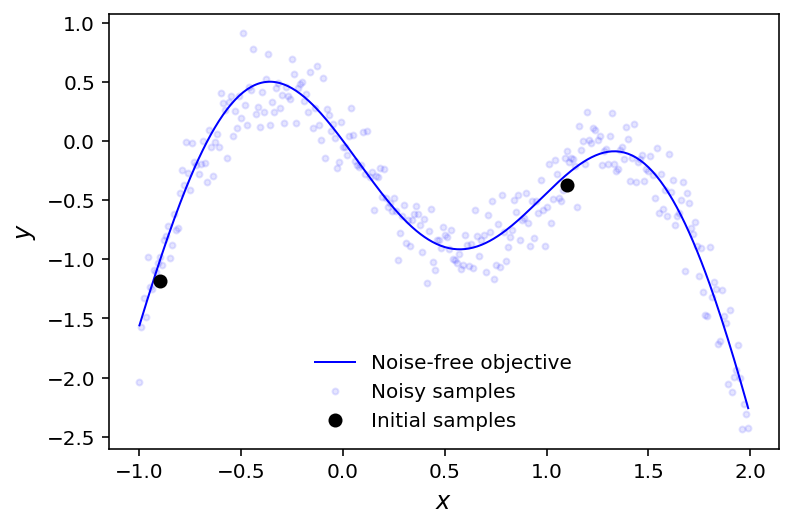

In [4]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'b', lw=1, label='Noise-free objective')
plt.plot(X, f(X), 'b .', alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'k o', label='Initial samples')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.legend(frameon=False);

Goal is to find the global optimum on the left in a small number of steps. The next step is to implement the acquisition function as `expected_improvement` function.

In [5]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

We also need a function that proposes the next sampling point by computing the location of the acquisition function maximum. Optimization is restarted `n_restarts` times to avoid local optima.

In [6]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, xi=0, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr, xi)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

Now we have all components needed to run Bayesian optimization with the algorithm outlined above. The Gaussian process in the following example is configured with a [Matérn kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) which is a generalization of the squared exponential kernel or RBF kernel. The known noise level is configured with the `alpha` parameter.

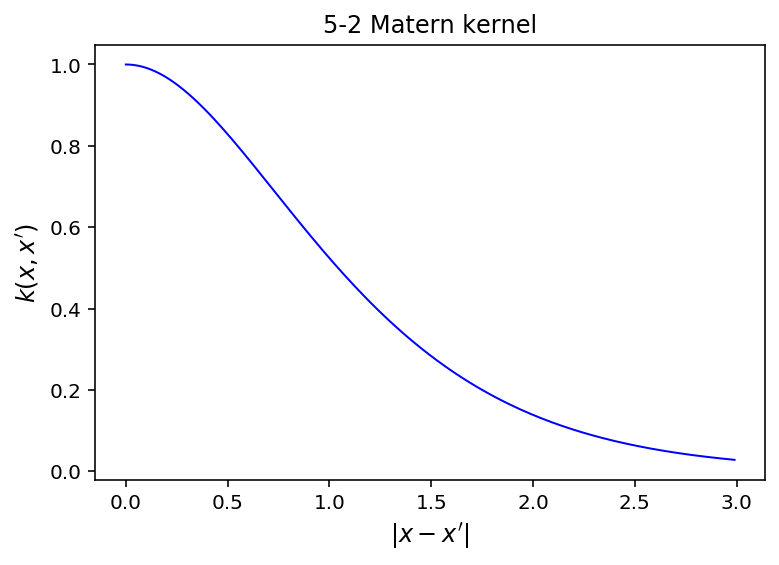

In [7]:
# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

plt.plot(X-X[0], m52(X)[:,0], 'b', lw=1)
plt.xlabel('$|x-x\'|$', fontsize=12)
plt.ylabel('$k(x,x\')$', fontsize=12)
plt.title('5-2 Matern kernel', fontsize=12);

Bayesian optimization runs for 10 iterations. In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

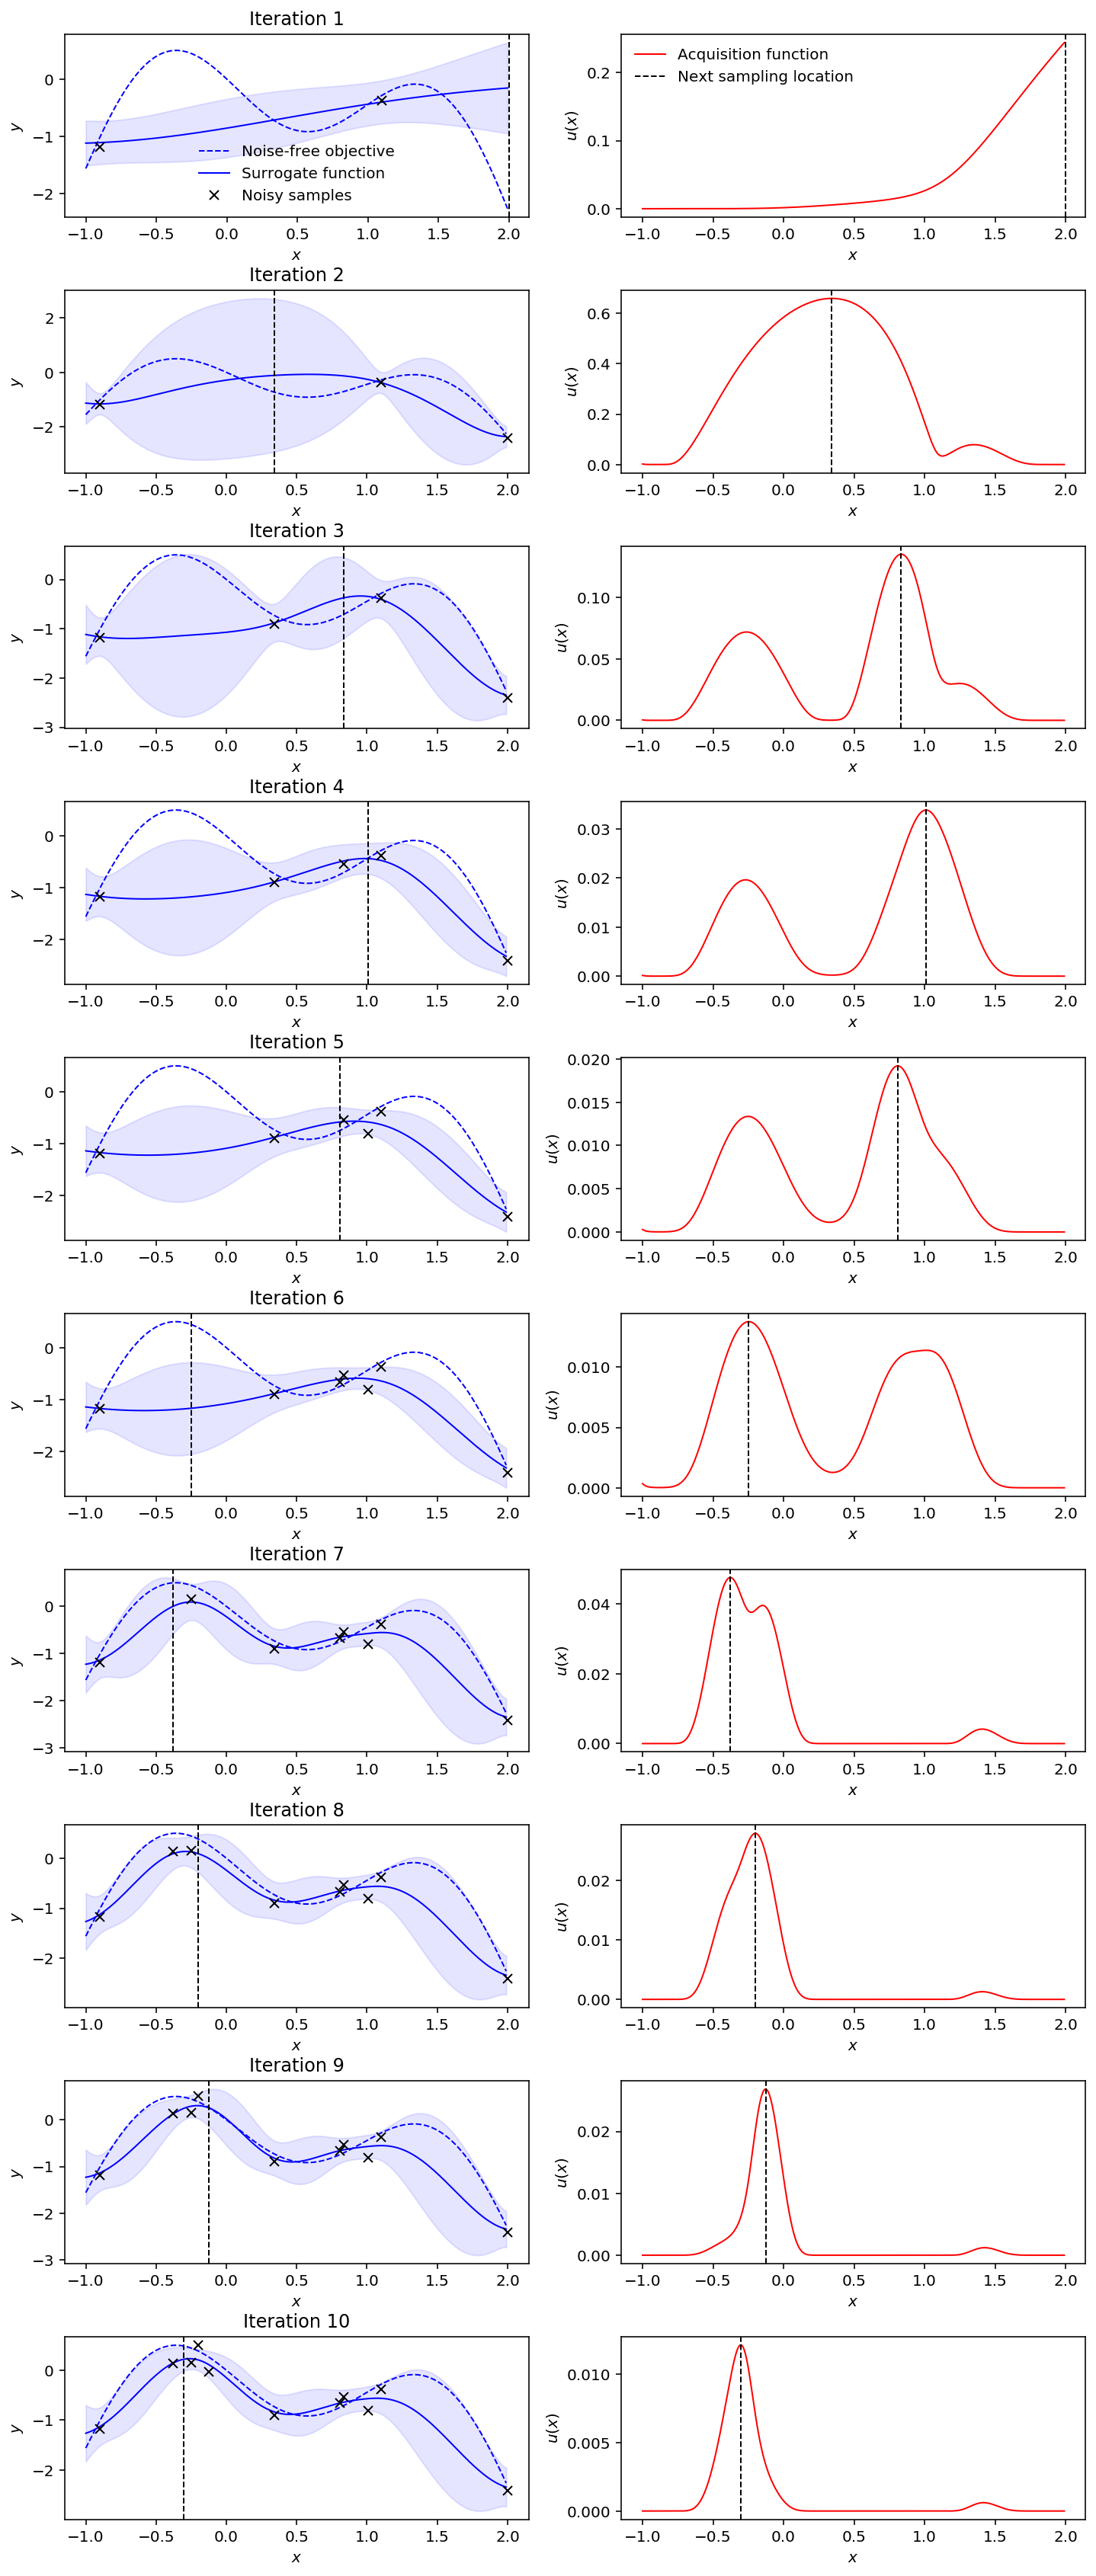

In [8]:
# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10
xi = 0.1 # exploration-exploitation

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds, xi)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    bou.plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    bou.plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr, xi), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Note how the two initial samples initially drive search into the direction of the local maximum on the right side but exploration allows the algorithm to escape from that local optimum and find the global optimum on the left side. Also note how sampling point proposals often fall within regions of high uncertainty (exploration) and are not only driven by the highest surrogate function values (exploitation).

A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps.

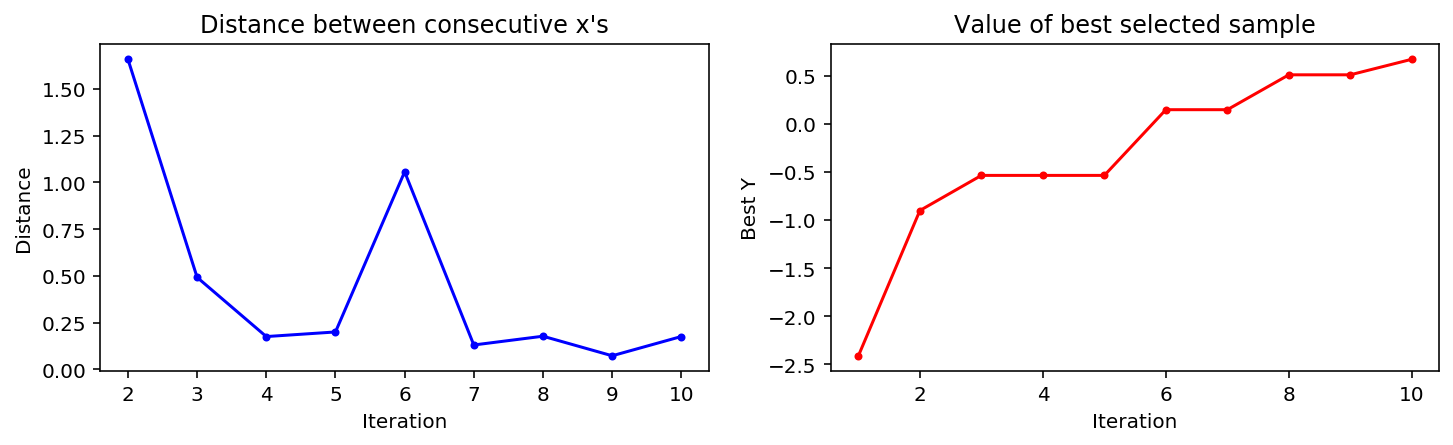

In [9]:
bou.plot_convergence(X_sample, Y_sample)

# Bayesian optimization libraries

This type of Bayesian optimization can be performed more directly using scikit-optimize.

## Scikit-optimize
[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on scikit-learn. It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values. The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

/Users/kjmbishop/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


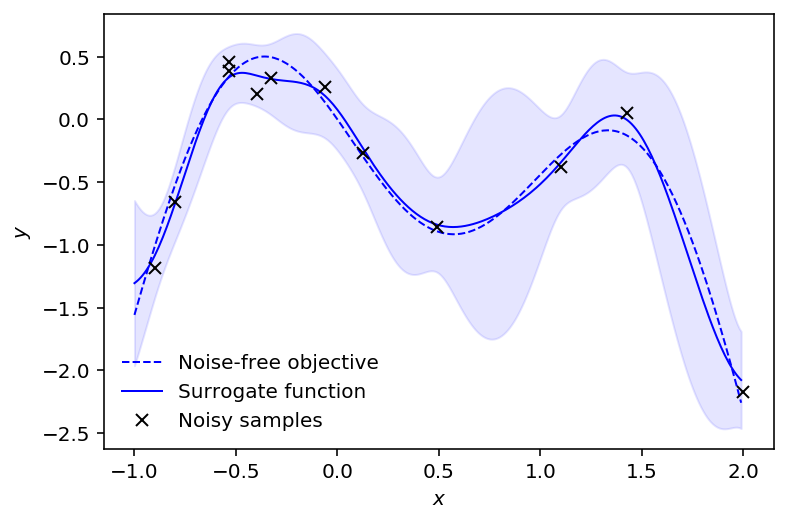

In [10]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=xi,              # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
bou.plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

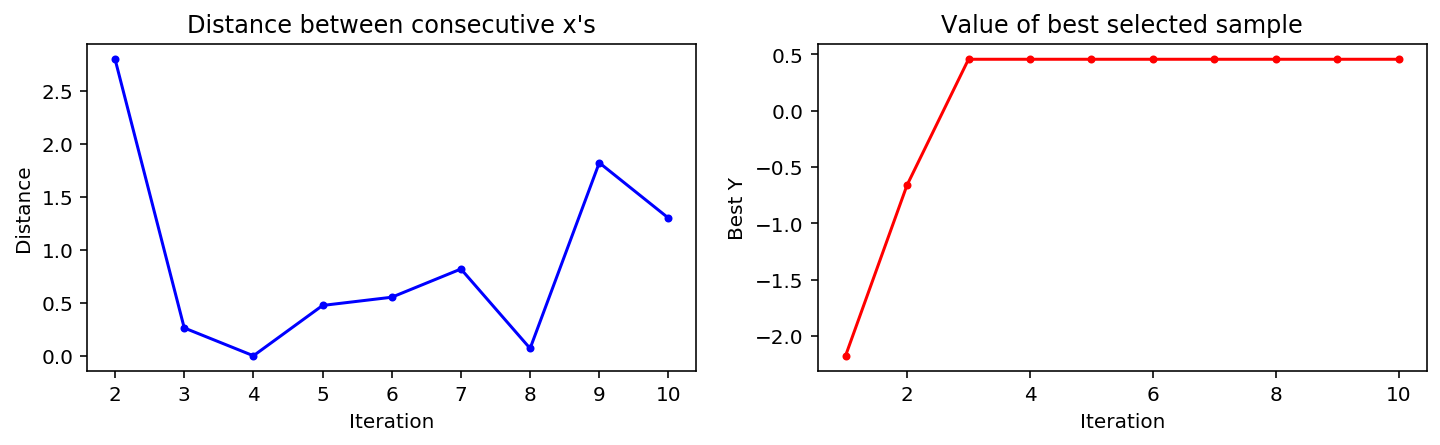

In [11]:
bou.plot_convergence(np.array(r.x_iters), -r.func_vals)